In [2]:
from pref_extract import find_restaurants, extract_all_preferences, extract_preference
import pandas as pd

21676
1297
Rate is:  0.8339869281045752


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\karst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Epoch 1/12
339/339 [==============================] - 1s 3ms/step - loss: 0.5204 - accuracy: 0.8993 - val_loss: 1.3279 - val_accuracy: 0.8068
Epoch 2/12
339/339 [==============================] - 1s 3ms/step - loss: 0.1127 - accuracy: 0.9691 - val_loss: 1.6579 - val_accuracy: 0.8073
Epoch 3/12
339/339 [==============================] - 2s 7ms/step - loss: 0.0756 - accuracy: 0.9802 - val_loss: 1.8402 - val_accuracy: 0.8097
Epoch 4/12
339/339 [==============================] - 1s 3ms/step - loss: 0.0602 - accuracy: 0.9851 - val_loss: 1.9865 - val_accuracy: 0.8078
Epoch 5/12
339/339 [==============================] - 1s 3ms/step - loss: 0.0503 - accuracy: 0.9870 - val_loss: 2.1015 - val_accuracy: 0.8097
Epoch 6/12
339/339 [==============================] - 1s 3ms/step - loss: 0.0441 - accuracy: 0.9889 - val_loss: 2.1709 - val_accuracy: 0.8099
Epoch 7/12
339/339 [==============================] - 1s 2ms/step - loss: 0.0391 - accuracy: 0.9898 - val_loss: 2.2336 - val_accuracy: 0.8073
Epoch 

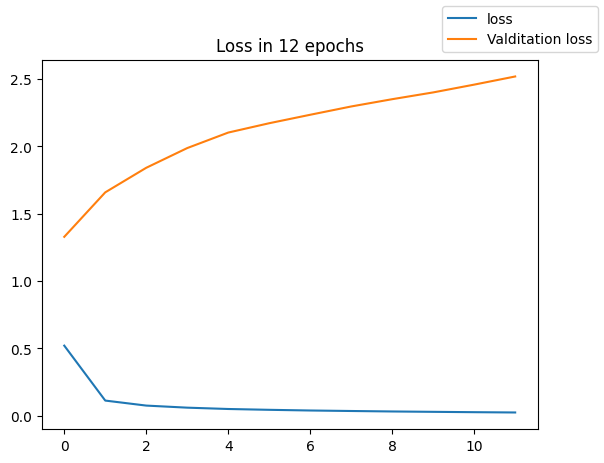

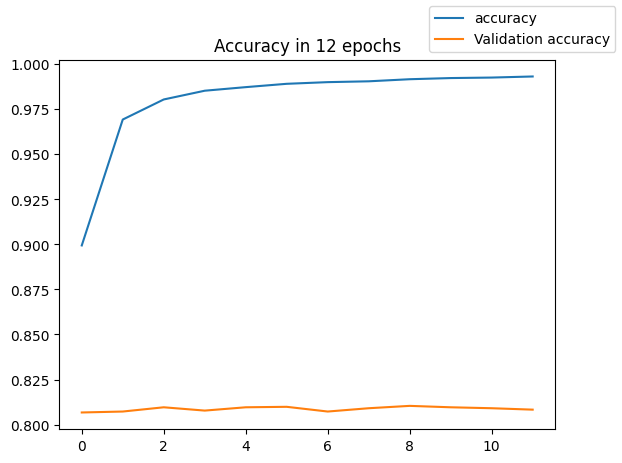

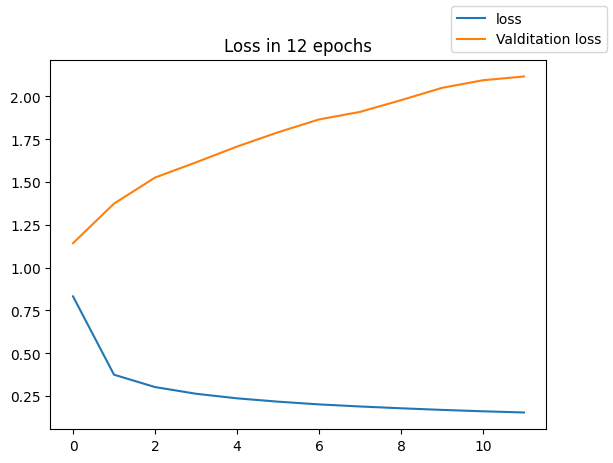

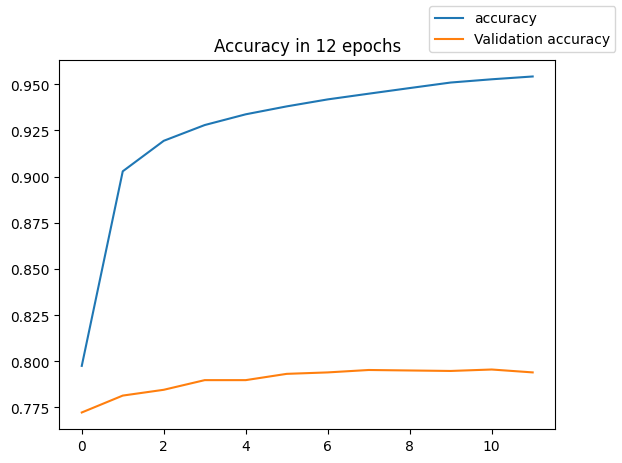

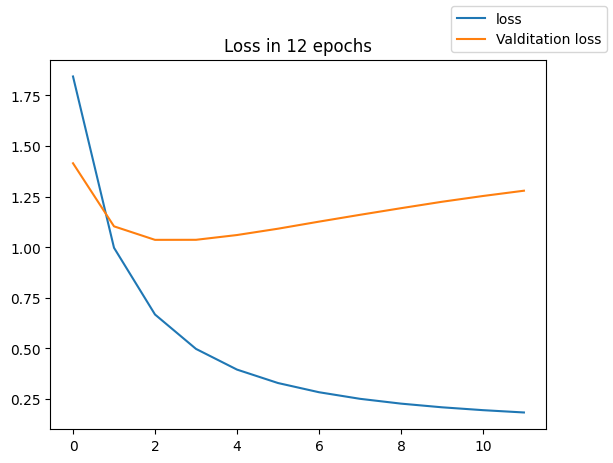

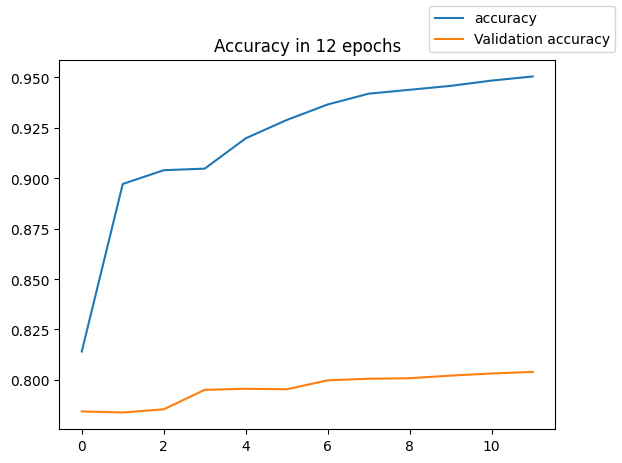

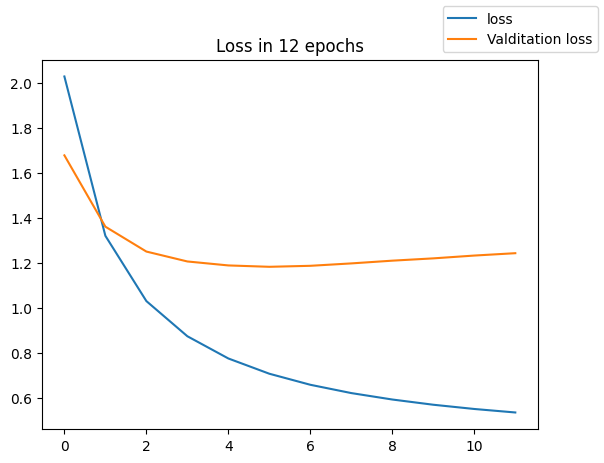

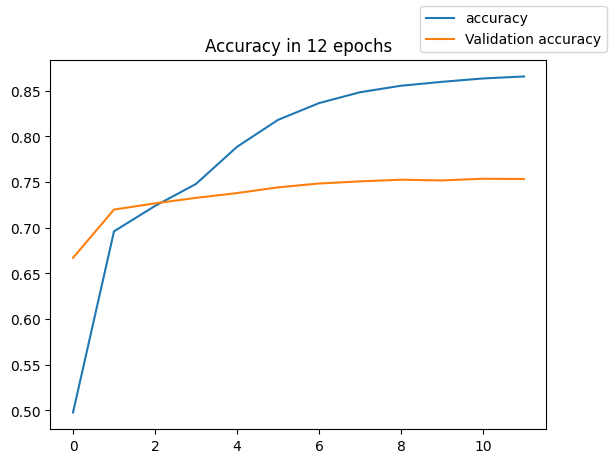

In [34]:
import importlib
import baseline
importlib.reload(baseline)
from baseline import prediction 

In [4]:
import regex as re
restaurant_info = pd.read_csv('restaurant_info.csv')

In [5]:
# Possible state transitions, not used, only to look at
# state_transition_possibilities = {
#     1: [2, 9],          
#     2: [2, 3, 9],
#     3: [3, 4, 9],
#     4: [4, 5, 9],
#     5: [6, 7, 9],
#     6: [5, 9],
#     7: [5, 8, 9],
#     8: [8, 9]
# }

In [35]:
class StateMachine:
    def __init__(self, restaurant_info):
        self.state = 1
        self.preferences = {
            'food_type': None,
            'area': None,
            'price': None
        }
        self.restaurant_info = restaurant_info
        self.restaurants_options = pd.DataFrame()
        self.selected_rest = ""
        self.restaurant_name = ""
        self.area = ""
        self.price = ""
        self.food_type = ""
        self.request_answer = ""
        self.requested_info = ""
        self.input_text = ""
        self.synonyms = {
            'area': ["area", "location", "part", "zone","sector","district"],
            'food_type': ["food", "type", "kitchen", "food type","cuisine","taste"],
            'price': ["price", "costs", "luxury", "amount","costs"]
        }
        # TODO - add more messages
        self.message_dict = {
            1: "Welcome to FeastFinder, I will help find you a restaurant. Please tell what type of food would you like to eat, where, and in what price range",
            2: "In what area do you want to have dinner?",
            3: "What cuisine are you looking for?",
            4: "In what price range should the restaurant be?",
            5: 'Looking for a restaurant...',
            6: "I'm sorry, I don't see any restaurants matching your preferences in my database. Try providing different preferences.",
            7: f'{self.restaurant_name} is located in {self.area} and is a {self.price} {self.food_type}. Does it sounds good?',
            8: f'{self.requested_info} of {self.restaurant_name} is {self.request_answer}',
            9: "I hope you'll have a great time. Bye bye!",
            10: f"That is unfortunate. What do you think of {self.restaurant_name}",
            11: "That is not what I expected"
        }

        print(self.message_dict[self.state])
        utterance = input()
        self.change_state(utterance)
        

    def pattern_recog(self, utterance):
        """
        We recognize the pattern "any X". It returns X. It returns a list of all instances of X
        """
        matches = re.findall(r'\bany\b\s+(\w+)', utterance)
        if matches:
            return matches
        else:
            return None
        
    def update_dict(self, old: dict, new: dict) -> dict:
        old.update( (k,v) for k,v in new.items() if v is not None)
        return old

    def any_update(self, words_after_any: list, orig_words: list):
        for word in words_after_any:
            for orig_word in orig_words: 
                if extract_preference(word, self.synonyms[orig_word], 2):
                    self.preferences = self.update_dict(self.preferences, {orig_word: "any"})

    def change_state(self, utterance = None):
        next_state, if_message = self.predict_next_state(utterance)
        if if_message:
            print(self.message_dict[next_state])
            utterance = input()
            self.state = next_state
            self.change_state(utterance)
        else:
            self.state = next_state
            self.change_state(utterance)

    def predict_next_state(self, utterance = None) -> tuple[int, bool]:
        """
        If the state should send a message, and then wait for user answer,
        it returns 'True'. If not, eg. state 2->4, returns False.
        :param utterance: 
        :return: tuple(next state number, if message sent) 
        """
        category = ""
        if utterance != None:
            category = prediction([utterance])
        if category == 'thankyou':
            return 9, True
        
        if self.state == 1:
            if utterance != None:
                self.preferences = extract_all_preferences(utterance)
            return 2, False
        
        if self.state == 2:
            self.preferences = self.update_dict(self.preferences, extract_all_preferences(utterance))
            if self.pattern_recog(utterance) != None:
                self.any_update( self.pattern_recog(utterance), ["area"])
            if self.preferences['area'] is None:
                return 2, True
            else:
                return 3, False
            
        if self.state == 3:
            self.preferences = self.update_dict(self.preferences, extract_all_preferences(utterance))
            if self.pattern_recog(utterance) != None:
                self.any_update( self.pattern_recog(utterance), ["food_type"])
            if self.preferences['food_type'] is None:
                return 3, True
            else:
                return 4, False
            
        if self.state == 4:
            self.preferences = self.update_dict(self.preferences, extract_all_preferences(utterance))
            if self.pattern_recog(utterance) != None:
                self.any_update( self.pattern_recog(utterance), ["price"])
            if self.preferences['price'] is None:
                return 4, True
            else:
                return 5, False
        
        if self.state == 5:
            print("pref: ", self.preferences)
            self.restaurants_options = find_restaurants(restaurant_info, self.preferences)
            if (self.restaurants_options.empty):
                return 6, True
            else:
                self.get_restaurant()
                message = f'{self.restaurant_name} is located in {self.area} and is a {self.price} {self.food_type}. Does it sound good?'
                self.message_dict[7] = message 
                return 7, True
        
        if self.state == 6:
            self.preferences = self.update_dict(self.preferences, extract_all_preferences(utterance))
            if self.pattern_recog(utterance) != None:
                self.any_update( self.pattern_recog(utterance), ["price"])
            self.restaurants_options = find_restaurants(self.restaurant_info, self.preferences)
            return 5, False
            
        if self.state == 7:
            # TODO - handle regalts category well and the else statement well
            if category == 'request':
                return 8, False
            if category == 'regalts':
                return 5, False
            if category == "affirm":
                return 9, False
            if category == "negate":
                return 10, False
            else:
                return 11, False
            
        if self.state == 8:
            message = ""
            request_dict = {
                'food': ["type", "food"],
                'phone': ["phone", "number"],
                'addr': ["adress", "location"],
                'postcode': ["postal", "postcode"]
             }
            for key, item in request_dict.items():
                if extract_preference(utterance, item, 2) != None:
                    if key == "food":
                        key_name = "cuisine"
                    elif key == "phone":
                        key_name = "phone number"
                    elif key == "addr":
                        key_name = "location"
                    elif key == "postcode":
                        key_name = "postal code"

                    message = message + f"The {key_name} of {self.restaurant_name} is {self.selected_rest[key].values[0]} \n"
            
            self.message_dict[8] = message
            return 8, True
        
        if self.state == 9:
            # TODO - its basically end of dialog
            return 9, True
        
        if self.state == 10:
            if self.restaurants_options.empty:
                return 6, True
            self.get_restaurant()
            message1 = f"That is unfortunate. Does {self.restaurant_name} sound good?"
            self.message_dict[7] = message1
            return 7, True

    def get_restaurant(self):
        rest = self.restaurants_options.sample()
        self.selected_rest = rest
        self.restaurant_name =rest["restaurantname"].values[0]
        self.area = rest["area"].values[0]
        self.price = rest["pricerange"].values[0]
        self.food_type = rest["food"].values[0]
        self.restaurants_options = self.restaurants_options.drop(rest.index)
           
SM = StateMachine(restaurant_info)

print("hello")

Welcome to FeastFinder, I will help find you a restaurant. Please tell what type of food would you like to eat, where, and in what price range
What cuisine are you looking for?
pref:  {'food_type': 'chinese', 'area': 'south', 'price': 'cheap'}
the lucky star is located in south and is a cheap chinese. Does it sound good?
The phone number of the lucky star is 01223 244277 

The location of the lucky star is cambridge leisure park clifton way cherry hinton 

The location of the lucky star is cambridge leisure park clifton way cherry hinton 











The phone number of the lucky star is 01223 244277 



KeyboardInterrupt: Interrupted by user